# Combined Data Extraction Workflow

This notebook creates a merged NetCDF file with 2D arrays combining precipitation and SWE data at relevant coordinates. 

## Workflow Steps:

1. **File Combination** → Combined NetCDF files (If the downloaded data are in small chunks)
2. **Spatial data Extraction** → Extract data for the required area (If dataset contains data for a larger area than the study area)
3. **Create Merged 2D NetCDF** → Single file with combined data arrays

**Output**: Single merged NetCDF file with 2D precipitation and SWE arrays for the required study area

In [1]:
# Install required packages
#%pip install tqdm
#%pip install scipy
#%pip install scikit-learn
#%pip install pyyaml
#%pip install seaborn
#%pip install dask
#%pip install netcdf4

# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import glob
import os
import sys
from pathlib import Path
import fnmatch
import logging

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)



# Configuration


In [13]:
# Configuration
config = {
    'casr_SWE_input_dir': project_root / 'data' / 'input_data' / 'CaSR_SWE',
    'casr_P_input_dir': project_root / 'data' / 'input_data' / 'CaSR_precipitation',
    'casr_temp_input_dir': project_root / 'data' / 'input_data' / 'CaSR_air_temp',
    'casr_humidity_input_dir': project_root / 'data' / 'input_data' / 'CaSR_humidity',
    'casr_flux_input_dir': project_root / 'data' / 'input_data' / 'CaSR_solar_flux',
    'shapefile_dir': project_root / 'data' / 'input_data' / 'shapefiles'/'BowRiverBasin'/'Bow_elevation_combined.shp',
    'combined_casr_dir': project_root / 'data' / 'output_data' / 'combined_casr'/'1980_2024',
    'elevation_windows_dir': project_root / 'data' / 'output_data' / 'elevation'/'1980_2024',
    'merged_output_dir': project_root / 'data' / 'output_data' / 'merged_2d',
    'plots': project_root / 'data' / 'output_plots' / '1980_2024',
}

# Create output directories
#config['merged_output_dir'].mkdir(parents=True, exist_ok=True)

print("Configuration set")
print(f"Output directory: {config['merged_output_dir']}")

Configuration set
Output directory: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\merged_2d


In [3]:
# Read the shapefile using geopandas
bow_elevation = gpd.read_file(config['shapefile_dir'])
# Set CRS if not already set (assume WGS84)
if bow_elevation.crs is None:
    bow_elevation.set_crs(epsg=4326, inplace=True)
print(f"Bow elevation shapefile CRS: {bow_elevation.crs}")  

display(bow_elevation.head())

Bow elevation shapefile CRS: EPSG:4617


,PROVCD_1,VALDATE,EDITION,DATASETNAM,VERSION,COMPLEVEL,WSCMDA,WSCSDA,WSCSSDA,FDA,...,WSCSSDANAM,min,max,mean,count,std,median,PROVCD_2,elev_class,geometry
0,AB,20070208,1,05BM000,0,NHN-CL1,05,05B,05BM,05BM,...,Lower Bow - Crowfoot,776.0,1177.0,953.688214,9897452,71.132927,944.0,None,500_1000m,"POLYGON ((-112.58577 51.23024, -112.58519 51.2..."
1,AB,20070130,1,05BN000,0,NHN-CL1,05,05B,05BN,05BN,...,Lower Bow - Mouth,700.0,998.0,772.376015,9312616,32.852467,764.0,None,500_1000m,"POLYGON ((-112.4962 50.71881, -112.49566 50.71..."
2,AB,20070226,1,05BH000,0,NHN-CL1,05,05B,05BH,05BH,...,Central Bow - Jumpingpond,1038.0,2479.0,1259.913722,4121228,176.434021,1227.0,None,1000_1500m,"POLYGON ((-113.93263 51.12563, -113.93288 51.1..."
3,AB,20070228,1,05BK000,0,NHN-CL1,05,05B,05BK,05BK,...,Fish (Alta.),981.0,1777.0,1226.170423,1151005,126.086335,1194.0,None,1000_1500m,"POLYGON ((-114.10188 50.95504, -114.0975 50.95..."
4,AB,20070302,1,05BE000,0,NHN-CL1,05,05B,05BE,05BE,...,Upper Bow - Policeman,1146.0,3054.0,1601.837836,1655101,376.052387,1437.0,None,1500_2000m,"POLYGON ((-114.72215 51.33033, -114.72235 51.3..."


In [16]:
# List all NetCDF files
file_pattern = str(config['casr_flux_input_dir'] / "CaSR_v3.1_P_FB_SFC_rlon246-280_rlat421-455*.nc")
file_list = sorted(glob.glob(file_pattern))

# Prepare an empty list to collect clipped data
clipped_list = []

for nc_file in file_list:
    swe = xr.open_dataset(nc_file)
    dataframe = swe.to_dataframe().reset_index()

    # Convert lon from 0-360 to -180 to 180 format before creating geometry
    if 'lon' in dataframe.columns:
        dataframe['lon'] = ((dataframe['lon'] + 180) % 360) - 180

    # Create GeoDataFrame with correct lon/lat
    gdf_swe = gpd.GeoDataFrame(
        dataframe,
        geometry=gpd.points_from_xy(dataframe['lon'], dataframe['lat']),
        crs='EPSG:4326'
    )

    # Ensure gdf has a CRS
    if gdf_swe.crs is None:
        gdf_swe.set_crs(epsg=4326, inplace=True)

    # Check bow_elevation CRS and reproject if necessary
    if bow_elevation is None or not hasattr(bow_elevation, "crs"):
        raise ValueError("bow_elevation GeoDataFrame not found or has no CRS. Set bow_elevation.crs before clipping.")
    if bow_elevation.crs is None:
        raise ValueError("bow_elevation.crs is None. Please set the CRS for bow_elevation before clipping.")

    # Reproject shapefile to match gdf_swe CRS (do not overwrite original unless desired)
    if bow_elevation.crs != gdf_swe.crs:
        bow_elevation_proj = bow_elevation.to_crs(gdf_swe.crs)
    else:
        bow_elevation_proj = bow_elevation

    # Clip to shapefile
    gdf_swe_clipped = gpd.clip(gdf_swe, bow_elevation_proj)

    # Append to list
    clipped_list.append(gdf_swe_clipped)
    print(f"Processed {nc_file}: {len(gdf_swe_clipped)} points clipped.")

# Concatenate all clipped data (handle empty list)
if clipped_list:
    all_clipped = pd.concat(clipped_list, ignore_index=True)
else:
    all_clipped = pd.DataFrame()
    print("No clipped data collected; clipped_list is empty.")

# Define output_path if not already defined
output_path = str(config['combined_casr_dir']) + os.sep

# Save to CSV
output_file = config['casr_flux_input_dir'] / 'bow_flux_data_rlon246-280_rlat421-455.csv'
all_clipped.to_csv(output_file, index=False)
print(f"Extracted SWE data saved to {output_file}")

# Display a sample
#display(all_clipped.head())

Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_solar_flux\CaSR_v3.1_P_FB_SFC_rlon246-280_rlat421-455_1980-1983.nc: 3751848 points clipped.
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_solar_flux\CaSR_v3.1_P_FB_SFC_rlon246-280_rlat421-455_1984-1987.nc: 3751848 points clipped.
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_solar_flux\CaSR_v3.1_P_FB_SFC_rlon246-280_rlat421-455_1988-1991.nc: 3751848 points clipped.
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_solar_flux\CaSR_v3.1_P_FB_SFC_rlon246-280_rlat421-455_1992-1995.nc: 3751848 points clipped.
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdrough

In [18]:
# open csv files
bow_swe_data1 = pd.read_csv(config['casr_flux_input_dir'] / 'bow_flux_data_rlon211-245_rlat421-455.csv')
bow_swe_data2 = pd.read_csv(config['casr_flux_input_dir'] / 'bow_flux_data_rlon246-280_rlat386-420.csv')
bow_swe_data3 = pd.read_csv(config['casr_flux_input_dir'] / 'bow_flux_data_rlon246-280_rlat421-455.csv')

# drop rows with NaN CaSR_v3.1_P_SWE_LAND
#bow_swe_data1 = bow_swe_data1.dropna(subset=['CaSR_v3.1__TT_1.5m'])
#bow_swe_data2 = bow_swe_data2.dropna(subset=['CaSR_v3.1__TT_1.5m'])
#bow_swe_data3 = bow_swe_data3.dropna(subset=['CaSR_v3.1__TT_1.5m'])
# concatenate all dataframes
bow_swe_data = pd.concat([bow_swe_data1, bow_swe_data2, bow_swe_data3], ignore_index=True)

# compute mean daily humidity per grid point and drop the hourly time
humidity_col = 'CaSR_v3.1_P_FB_SFC'
bow_swe_data['time'] = pd.to_datetime(bow_swe_data['time']).dt.date
bow_swe_data = bow_swe_data.groupby(['time', 'lat', 'lon'], as_index=False)[humidity_col].mean()
# Save the combined data to a CSV file
output_file_combined = config['casr_flux_input_dir'] / 'bow_flux_data_combined.csv'
bow_swe_data.to_csv(output_file_combined, index=False)  
print(f"Combined SWE data saved to {output_file_combined}")
# Display the combined data
display(bow_swe_data.head())

Combined SWE data saved to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_solar_flux\bow_flux_data_combined.csv


,time,lat,lon,CaSR_v3.1_P_FB_SFC
0,1979-12-31,49.984460,-111.714264,117.069602
1,1979-12-31,50.009690,-111.580780,116.660511
2,1979-12-31,50.045334,-111.887510,118.000000
3,1979-12-31,50.070770,-111.753970,116.767046
4,1979-12-31,50.096050,-111.620240,115.008522


In [19]:
print(bow_swe_data)

               time        lat         lon  CaSR_v3.1_P_FB_SFC
0        1979-12-31  49.984460 -111.714264          117.069602
1        1979-12-31  50.009690 -111.580780          116.660511
2        1979-12-31  50.045334 -111.887510          118.000000
3        1979-12-31  50.070770 -111.753970          116.767046
4        1979-12-31  50.096050 -111.620240          115.008522
...             ...        ...         ...                 ...
4224561  2024-12-31  51.557026 -116.422640            0.000000
4224562  2024-12-31  51.588097 -116.287110            0.000000
4224563  2024-12-31  51.619003 -116.151370            0.000000
4224564  2024-12-31  51.641434 -116.472960            0.000000
4224565  2024-12-31  51.672558 -116.337190            0.000000

[4224566 rows x 4 columns]


In [20]:
#convert lon from 0-360 to -180 to 180 format
bow_swe_data['lon'] = ((bow_swe_data['lon'] + 180) % 360) - 180


# convert to GeoDataFrame
gdf_bow_swe_data = gpd.GeoDataFrame(
    bow_swe_data,
    geometry=gpd.points_from_xy(bow_swe_data['lon'], bow_swe_data['lat']),
    crs='EPSG:4326'  # Assuming the coordinates are in WGS84
)

# Display the GeoDataFrames
display(gdf_bow_swe_data.head())

,time,lat,lon,CaSR_v3.1_P_FB_SFC,geometry
0,1979-12-31,49.984460,-111.714264,117.069602,POINT (-111.71426 49.98446)
1,1979-12-31,50.009690,-111.580780,116.660511,POINT (-111.58078 50.00969)
2,1979-12-31,50.045334,-111.887510,118.000000,POINT (-111.88751 50.04533)
3,1979-12-31,50.070770,-111.753970,116.767046,POINT (-111.75397 50.07077)
4,1979-12-31,50.096050,-111.620240,115.008522,POINT (-111.62024 50.09605)


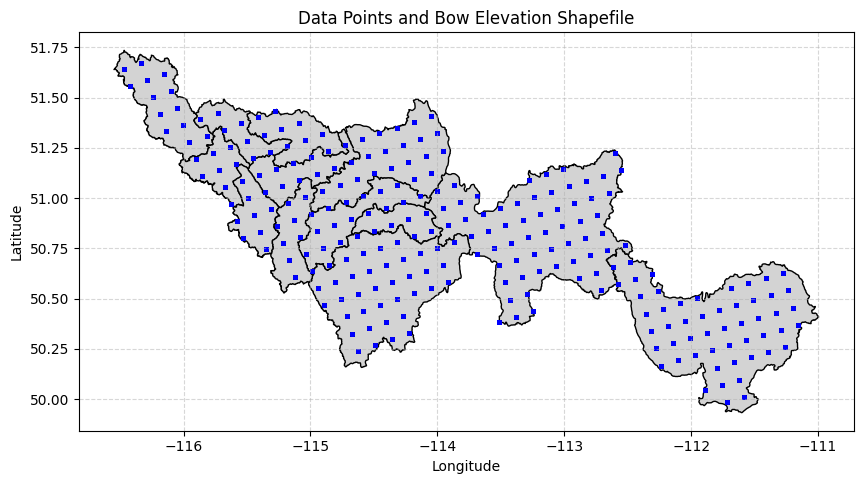

In [21]:
# plot data points and shapefile
fig, ax = plt.subplots(figsize=(10, 10))
bow_elevation.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_bow_swe_data.plot(ax=ax, color='blue', markersize=5, label='Data Points')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_title('Data Points and Bow Elevation Shapefile')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# 2. Open all precipitation data files and combine them into a single xarray dataset spatially and temporally


In [7]:
# List all NetCDF files
file_pattern = str(config['casr_P_input_dir'] / 'CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455*.nc')
file_list = sorted(glob.glob(file_pattern))

# Prepare an empty list to collect clipped data
clipped_list = []

for nc_file in file_list:
    swe = xr.open_dataset(nc_file)
    dataframe = swe.to_dataframe().reset_index()
    
    # Create GeoDataFrame
    gdf_swe = gpd.GeoDataFrame(
        dataframe,
        geometry=gpd.points_from_xy(dataframe['lon'], dataframe['lat']),
        crs='EPSG:4326'
    )
    # Convert lon from 0-360 to -180 to 180 format
    gdf_swe['lon'] = ((gdf_swe['lon'] + 180) % 360) - 180
    gdf_swe['geometry'] = gpd.points_from_xy(gdf_swe['lon'], gdf_swe['lat'])
    
    # Clip to shapefile
    gdf_swe_clipped = gpd.clip(gdf_swe, bow_elevation)
    
    # Append to list
    clipped_list.append(gdf_swe_clipped)
    print(f"Processed {nc_file}: {len(gdf_swe_clipped)} points clipped.")

# Concatenate all clipped data
all_clipped = pd.concat(clipped_list, ignore_index=True)

# Save to CSV
output_file = config['casr_P_input_dir'] / 'bow_precip_data_rlon246-280_rlat421-455.csv'
all_clipped.to_csv(output_file, index=False)
print(f"Extracted SWE data saved to {output_file}")

# Display a sample
#display(all_clipped.head())

Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_precipitation\CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455_1980-1983.nc: 3751848 points clipped.
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_precipitation\CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455_1984-1987.nc: 3751848 points clipped.
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_precipitation\CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455_1988-1991.nc: 3751848 points clipped.
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_precipitation\CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455_1992-1995.nc: 3751848 points clipped.
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documen

In [8]:
# open csv files
bow_precip_data1 = pd.read_csv(config['casr_P_input_dir'] / 'bow_precip_data_rlon211-245_rlat421-455.csv')
bow_precip_data2 = pd.read_csv(config['casr_P_input_dir'] / 'bow_precip_data_rlon246-280_rlat421-455.csv')
bow_precip_data3 = pd.read_csv(config['casr_P_input_dir'] / 'bow_precip_data_rlon246-280_rlat386-420.csv')

# drop rows with NaN CaSR_v3.1_P_SWE_LAND
bow_precip_data1 = bow_precip_data1.dropna(subset=['CaSR_v3.1_A_PR24_SFC'])
bow_precip_data2 = bow_precip_data2.dropna(subset=['CaSR_v3.1_A_PR24_SFC'])
bow_precip_data3 = bow_precip_data3.dropna(subset=['CaSR_v3.1_A_PR24_SFC'])
# concatenate all dataframes
bow_precip_data = pd.concat([bow_precip_data1, bow_precip_data2, bow_precip_data3], ignore_index=True)
# Save the combined data to a CSV file
output_file_combined = config['casr_P_input_dir'] / 'bow_precip_data_combined.csv'
bow_precip_data.to_csv(output_file_combined, index=False)  
print(f"Combined SWE data saved to {output_file_combined}")
# Display the combined data
display(bow_precip_data.head())

Combined SWE data saved to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_precipitation\bow_precip_data_combined.csv


,time,rlat,rlon,rotated_pole,CaSR_v3.1_A_PR24_SFC,lon,lat,geometry
0,1980-10-10 12:00:00,-4.32,-14.607224,1,0.000010,-116.13797,51.334590,POINT (-116.13796997070312 51.334590911865234)
1,1982-07-19 12:00:00,-4.32,-14.607224,1,0.002766,-116.13797,51.334590,POINT (-116.13796997070312 51.334590911865234)
2,1983-10-12 12:00:00,-4.23,-14.607224,1,0.000024,-116.18750,51.419113,POINT (-116.1875 51.41911315917969)
3,1980-12-11 12:00:00,-4.23,-14.607224,1,0.004579,-116.18750,51.419113,POINT (-116.1875 51.41911315917969)
4,1981-07-21 12:00:00,-4.23,-14.607224,1,0.005400,-116.18750,51.419113,POINT (-116.1875 51.41911315917969)


In [9]:

#convert lon from 0-360 to -180 to 180 format
bow_precip_data['lon'] = ((bow_precip_data['lon'] + 180) % 360) - 180

# convert to GeoDataFrame
gdf_bow_precip_data = gpd.GeoDataFrame(
    bow_precip_data,
    geometry=gpd.points_from_xy(bow_precip_data['lon'], bow_precip_data['lat']),
    crs='EPSG:4326'  # Assuming the coordinates are in WGS84
)

# Display the GeoDataFrames
display(gdf_bow_precip_data.head())

,time,rlat,rlon,rotated_pole,CaSR_v3.1_A_PR24_SFC,lon,lat,geometry
0,1980-10-10 12:00:00,-4.32,-14.607224,1,0.000010,-116.13797,51.334590,POINT (-116.13797 51.33459)
1,1982-07-19 12:00:00,-4.32,-14.607224,1,0.002766,-116.13797,51.334590,POINT (-116.13797 51.33459)
2,1983-10-12 12:00:00,-4.23,-14.607224,1,0.000024,-116.18750,51.419113,POINT (-116.1875 51.41911)
3,1980-12-11 12:00:00,-4.23,-14.607224,1,0.004579,-116.18750,51.419113,POINT (-116.1875 51.41911)
4,1981-07-21 12:00:00,-4.23,-14.607224,1,0.005400,-116.18750,51.419113,POINT (-116.1875 51.41911)


In [11]:
bow_swe_data = pd.read_csv(config['casr_SWE_input_dir'] / 'bow_swe_data_combined.csv')

#convert lon from 0-360 to -180 to 180 format
bow_swe_data['lon'] = ((bow_swe_data['lon'] + 180) % 360) - 180


# convert to GeoDataFrame
gdf_bow_swe_data = gpd.GeoDataFrame(
    bow_swe_data,
    geometry=gpd.points_from_xy(bow_swe_data['lon'], bow_swe_data['lat']),
    crs='EPSG:4326'  # Assuming the coordinates are in WGS84
)

# Display the GeoDataFrames
display(gdf_bow_swe_data.head())

,time,rlat,rlon,rotated_pole,CaSR_v3.1_P_SWE_LAND,lon,lat,geometry
0,1980-10-10 12:00:00,-4.32,-14.607224,1,0.878418,-116.13797,51.334590,POINT (-116.13797 51.33459)
1,1982-07-19 12:00:00,-4.32,-14.607224,1,0.515625,-116.13797,51.334590,POINT (-116.13797 51.33459)
2,1983-10-12 12:00:00,-4.23,-14.607224,1,6.875000,-116.18750,51.419113,POINT (-116.1875 51.41911)
3,1980-12-11 12:00:00,-4.23,-14.607224,1,118.125000,-116.18750,51.419113,POINT (-116.1875 51.41911)
4,1981-07-21 12:00:00,-4.23,-14.607224,1,0.000000,-116.18750,51.419113,POINT (-116.1875 51.41911)


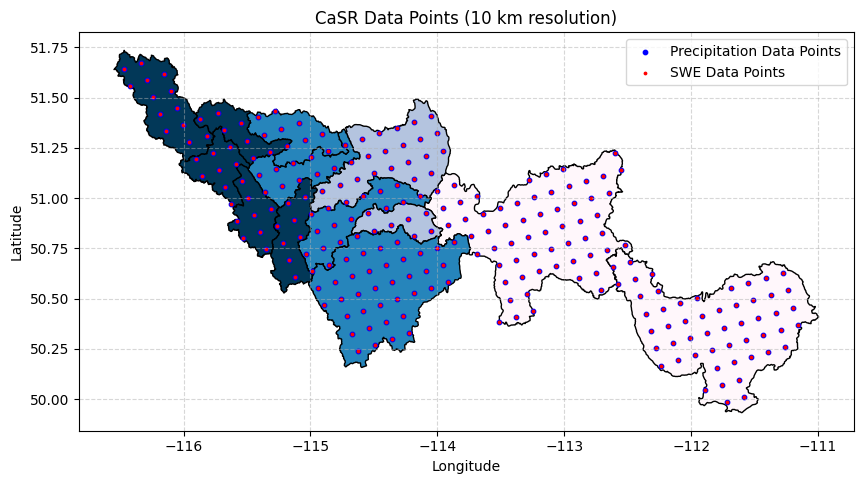

In [22]:
# drop repeated coordinates based on geometry column
gdf_bow_precip_data1 = gdf_bow_precip_data.drop_duplicates(subset="geometry")
gdf_bow_swe_data1 = gdf_bow_swe_data.drop_duplicates(subset="geometry")

# plot data points and shapefile
fig, ax = plt.subplots(figsize=(10, 10))

# Create elevation class column based on available elevation field.
# Many shapefiles use different column names; try common candidates and fall back to 'Unknown'
bins = [500, 1000, 1500, 2000, 2500]
labels = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']

# Try a list of possible elevation column names
elev_candidates = [
    'mean', 'elev_mean', 'ELEV_MEAN', 'elevation', 'ELEVATION',
    'MEAN_ELEV', 'elev', 'ELEV', 'VALUE', 'VAL', 'MEAN'
]

elev_col = None
for c in elev_candidates:
    if c in bow_elevation.columns:
        elev_col = c
        break

if elev_col is not None:
    # ensure numeric dtype
    bow_elevation['__elev_tmp'] = pd.to_numeric(bow_elevation[elev_col], errors='coerce')
    bow_elevation['elev_class'] = pd.cut(bow_elevation['__elev_tmp'], bins=bins, labels=labels, include_lowest=True, right=False)
    # Ensure elev_class is a categorical type with desired order
    bow_elevation['elev_class'] = pd.Categorical(
        bow_elevation['elev_class'],
        categories=labels,
        ordered=True
    )
    bow_elevation.plot(ax=ax, column='elev_class', cmap='PuBu', legend=True, edgecolor='black')
    # drop temporary column
    bow_elevation.drop(columns='__elev_tmp', inplace=True)
else:
    # No elevation column found — create an 'Unknown' category and plot without classification
    bow_elevation['elev_class'] = 'Unknown'
    bow_elevation['elev_class'] = pd.Categorical(bow_elevation['elev_class'], categories=['Unknown'], ordered=False)
    bow_elevation.plot(ax=ax, color='lightgrey', edgecolor='black', label='Bow Elevation')

# Plot the deduplicated CaSR points (smaller sets) to avoid massive plotting
gdf_bow_precip_data1.plot(ax=ax, color='blue', markersize=10, label='Precipitation Data Points')
gdf_bow_swe_data1.plot(ax=ax, color='red', markersize=3, label='SWE Data Points')

ax.grid(True, linestyle='--', alpha=0.5)
ax.set_title('CaSR Data Points (10 km resolution)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

# Save plot
plt.savefig(config['plots'] / 'bow_data_points_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [24]:
swe_data = pd.read_csv(config['casr_SWE_input_dir'] / 'bow_swe_data_combined.csv')
precip_data = pd.read_csv(config['casr_P_input_dir'] / 'bow_precip_data_combined.csv')
mean_temp_data = pd.read_csv(config['casr_temp_input_dir'] / 'bow_temp_data_combined.csv')
max_temp_data = pd.read_csv(config['casr_temp_input_dir'] / 'bow_max_temp_data_combined.csv')
humidity_data = pd.read_csv(config['casr_humidity_input_dir'] / 'bow_humidity_data_combined.csv')
flux_data = pd.read_csv(config['casr_flux_input_dir'] / 'bow_flux_data_combined.csv')

In [28]:
# Prepare and merge multiple DataFrames on ['time','lon','lat'] sequentially.
# Make sure time columns have consistent dtype and avoid duplicate measurement column names.

# Ensure 'time' is datetime in all input DataFrames
for df in [swe_data, precip_data, mean_temp_data, max_temp_data, humidity_data, flux_data]:
    df['time'] = pd.to_datetime(df['time'])

# Rename measurement columns that would otherwise collide
swe_data = swe_data.rename(columns={'CaSR_v3.1_P_SWE_LAND': 'SWE'})
precip_data = precip_data.rename(columns={'CaSR_v3.1_A_PR24_SFC': 'Precipitation'})
mean_temp = mean_temp_data.rename(columns={'CaSR_v3.1_P_TT_1.5m': 'Mean_Temp'})
max_temp = max_temp_data.rename(columns={'CaSR_v3.1_P_TT_1.5m': 'Max_Temp'})
humidity = humidity_data.rename(columns={'CaSR_v3.1_P_HU_1.5m': 'Humidity'})
flux = flux_data.rename(columns={'CaSR_v3.1_P_FB_SFC': 'Flux'})

# Keep original SWE and Precipitation column names so later code can rename them as expected
dfs_to_merge = [swe_data, precip_data, mean_temp, max_temp, humidity, flux]

# Sequential merge to avoid pd.merge() positional-argument issues
combined_data = dfs_to_merge[0]
for df in dfs_to_merge[1:]:
    combined_data = pd.merge(combined_data, df, on=['time', 'lon', 'lat'], how='inner')

# Display the first few rows of the combined dataframe
display(combined_data)

,time,rlat_x,rlon_x,rotated_pole_x,SWE,lon,lat,geometry_x,rlat_y,rlon_y,rotated_pole_y,Precipitation,geometry_y,Mean_Temp,Max_Temp,Humidity,Flux


In [24]:
# Rename columns to standard names for easier use
combined_data = combined_data.rename(
	columns={
		'CaSR_v3.1_P_SWE_LAND': 'SWE',
		'CaSR_v3.1_A_PR24_SFC': 'Precipitation'
	}
)

#keep only the columns of interest (use the already renamed columns)
combined_data = combined_data[['time', 'lon', 'lat', 'SWE', 'Precipitation']]

#conver back to dataframe
combined_data = pd.DataFrame(combined_data)

# convert precipitation from m to mm
combined_data['Precipitation'] = combined_data['Precipitation'] * 1000  # Convert from meters to millimeters
# Convert SWE from kg/m^2 to mm (assuming density of water is 1000 kg/m^3)

# Convert 'time' column to datetime format
combined_data['time'] = pd.to_datetime(combined_data['time']).dt.date

# add a new column Grid_id with unique values based on lat and lon
# Assign unique integer Grid_id for each unique (lat, lon) pair
unique_coords = combined_data[['lat', 'lon']].drop_duplicates().reset_index(drop=True)
unique_coords['Grid_id'] = range(1, len(unique_coords) + 1)
combined_data = combined_data.merge(unique_coords, on=['lat', 'lon'], how='left')
combined_data['Grid_id'] = combined_data['Grid_id'].astype(int)

# Reorder columns to have 'Grid_id' at the beginning and use new column names
combined_data = combined_data[['Grid_id', 'time', 'lon', 'lat', 'SWE', 'Precipitation']]

# Save the combined data to a CSV file
output_file_combined = config['merged_output_dir'] / 'bow_combined_data.csv'
combined_data.to_csv(output_file_combined, index=False)
print(f"Combined data saved to {output_file_combined}")
# Display the first few rows of the combined dataframe
display(combined_data)

Combined data saved to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\merged_2d\bow_combined_data.csv


,Grid_id,time,lon,lat,SWE,Precipitation
0,1,1980-10-10,-116.13797,51.334590,0.878418,0.009879
1,1,1982-07-19,-116.13797,51.334590,0.515625,2.765854
2,2,1983-10-12,-116.18750,51.419113,6.875000,0.023846
3,2,1980-12-11,-116.18750,51.419113,118.125000,4.578907
4,2,1981-07-21,-116.18750,51.419113,0.000000,5.400473
...,...,...,...,...,...,...
4224304,257,2024-06-30,-111.62024,50.096050,0.000000,0.000000
4224305,257,2024-08-31,-111.62024,50.096050,0.000000,0.000000
4224306,257,2024-09-28,-111.62024,50.096050,0.000000,0.076506
4224307,257,2024-01-05,-111.62024,50.096050,0.625000,0.019896


In [25]:
# Prepare a GeoDataFrame for unique grid points
grid_points = gpd.GeoDataFrame(
    unique_coords,
    geometry=gpd.points_from_xy(unique_coords['lon'], unique_coords['lat']),
    crs='EPSG:4326'
)

# Spatial join to assign elevation class to each grid point
grid_points_with_elev = gpd.sjoin(grid_points, bow_elevation[['elev_class', 'geometry']], how='left', predicate='within')

# Merge elevation class back to combined_data
combined_data = combined_data.merge(
    grid_points_with_elev[['Grid_id', 'elev_class']],
    on='Grid_id',
    how='left'
)

# Rename the column for clarity
combined_data = combined_data.rename(columns={'elev_class': 'Elevation_Category'})

# Display the updated dataframe
display(combined_data)

,Grid_id,time,lon,lat,SWE,Precipitation,Elevation_Category
0,1,1980-10-10,-116.13797,51.334590,0.878418,0.009879,2000_2500m
1,1,1982-07-19,-116.13797,51.334590,0.515625,2.765854,2000_2500m
2,2,1983-10-12,-116.18750,51.419113,6.875000,0.023846,2000_2500m
3,2,1980-12-11,-116.18750,51.419113,118.125000,4.578907,2000_2500m
4,2,1981-07-21,-116.18750,51.419113,0.000000,5.400473,2000_2500m
...,...,...,...,...,...,...,...
4224304,257,2024-06-30,-111.62024,50.096050,0.000000,0.000000,500_1000m
4224305,257,2024-08-31,-111.62024,50.096050,0.000000,0.000000,500_1000m
4224306,257,2024-09-28,-111.62024,50.096050,0.000000,0.076506,500_1000m
4224307,257,2024-01-05,-111.62024,50.096050,0.625000,0.019896,500_1000m


In [26]:
# Save the combined data to a CSV file
output_file_combined = config['merged_output_dir'] / 'bow_combined_data.csv'
combined_data.to_csv(output_file_combined, index=False)
print(f"Combined data with elevation categories saved to {output_file_combined}")

Combined data with elevation categories saved to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\merged_2d\bow_combined_data.csv
